Attempt to solve: https://github.com/theislab/scanpy/issues/1366
Probably useful video: https://www.youtube.com/watch?v=h9wxtqoa1jY

In [1]:
import datashader as ds
from datashader import transfer_functions as tf
import matplotlib.pyplot as plt
from natsort import natsorted

import scanpy as sc
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.neighbors import RadiusNeighborsTransformer

In [2]:
adata = sc.read("/Users/isaac/data/10x_mouse_13MM_processed.h5ad", backed="r")

/Users/isaac/github/anndata/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/isaac/github/anndata/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
louvain_colors_old = dict(
    zip(
        adata.obs["louvain"].cat.categories, 
        adata.uns["louvain_colors"]
    )
)
del adata.uns["louvain_colors"]
louvain_colors_current = sc.pl._tools.scatterplots._get_palette(adata, values_key="louvain")

In [6]:
df = sc.get.obs_df(
    adata,
    ["louvain"],
    obsm_keys=[("X_umap", 0), ("X_umap", 1)]
)

In [7]:
pts = (
    ds.Canvas(500, 500)
    .points(df, "X_umap-0", "X_umap-1", agg=ds.count_cat("louvain"))
)

In [8]:
def pts_to_coords(pts:  xr.DataArray) -> pd.DataFrame:
    """
    Turning pixel data into "long" sparse format.
    
    One entry for each cluster, for each pixel it would occur in.
    """
    coords = pd.DataFrame(np.argwhere(np.asarray(pts)), columns=["x", "y", "cat"])
    coords["cat"] = pd.Categorical.from_codes(coords["cat"], categories=list(pts.coords.values())[2])
    return coords

def color_nodes(graph: dict) -> dict:
    """Graph coloring algorithm
    
    From @atarashansky: https://github.com/theislab/scanpy/issues/1366#issuecomment-763066249
    """
    color_map = {}
    for node in sorted(graph, key=lambda x: len(graph[x]), reverse=True):
        neighbor_colors = set(color_map.get(neigh) for neigh in graph[node])
        color_map[node] = next( 
            color for color in range(len(graph)) if color not in neighbor_colors
        )
    return color_map

def neighboring_clusters(pts: xr.DataArray) -> dict:
    """From array of (pixel, pixel, cluster) find which clusters neighbor eachother.
    """
    graph = {}
    coords = pts_to_coords(pts)
    cat = coords["cat"]

    radius_neighbor = RadiusNeighborsTransformer(metric="euclidean", radius=1)
    radius_neighbor.fit(coords.values[:, :2])
    g = radius_neighbor.radius_neighbors_graph()

    for k, v in coords.groupby("cat").indices.items():
        neighbors = np.unique(g[v].indices)
        graph[k] = natsorted(pd.unique(cat[neighbors]))

    return graph

In [11]:
graph = neighboring_clusters(pts)
palette = {k: sc.pl.palettes.default_28[v] for k, v in color_nodes(graph).items()}

Current scanpy coloring (38 unique colors out of 100),Graph coloring,Old scanpy coloring (20 colors w/ repeats)

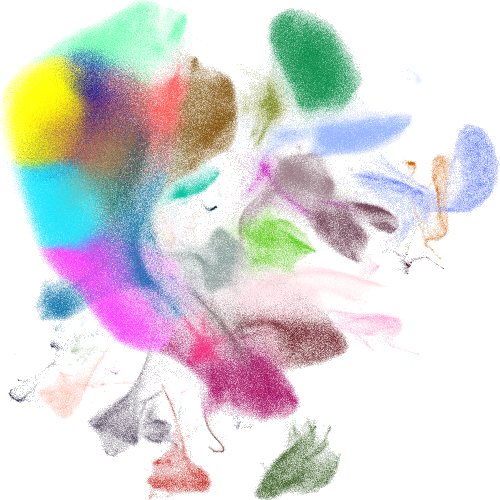
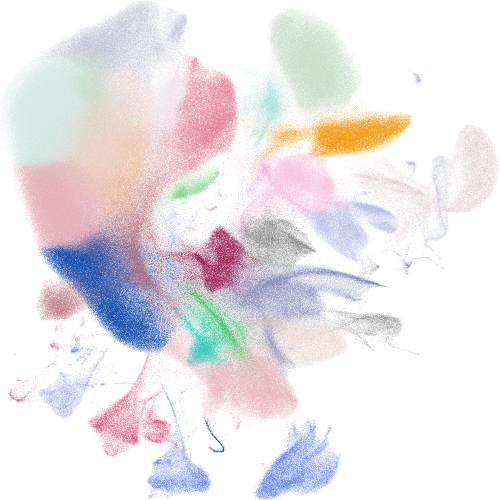
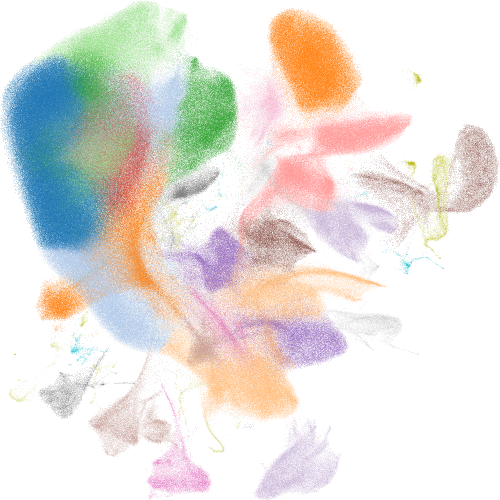

In [12]:
tf.Images(
    tf.shade(pts, color_key=louvain_colors_current, name="Current scanpy coloring (38 unique colors out of 100)"),
    tf.shade(pts, color_key=palette, name="Graph coloring "),
    tf.shade(pts, color_key=louvain_colors_old, name="Old scanpy coloring (20 colors w/ repeats)"),
)